# Team Members

- Kshitij Dahal - 1228236635
- Yash Rahul Bellap - 1228575454
- Atharva Gupta - 1222682656
- Rahul Pushparajan - 1226951910


## 1.A Numerical Estimation

In [20]:
from scipy.optimize import minimize
import numpy as np

# ReLU and neural network functions
def relu(x):
    return np.maximum(0, x)

def neural_network(x, W1, b1, W2, b2):
    z1 = relu(np.dot(W1, x) + b1)
    scores = np.dot(W2, z1) + b2
    return scores

# The objective function for the corrected dimensions
def objective_function(params, x1, x2, x3, x4):
    # Adjust unpacking parameters for the corrected architecture
    b1 = params[0:2]
    b2 = params[2:4]
    W1 = params[4:8].reshape((2, 2))  # Adjusted to match input dimension
    W2 = params[8:].reshape((2, 2))

    # The rest remains the same
    s1_x1, s2_x1 = neural_network(x1, W1, b1, W2, b2)
    s1_x2, s2_x2 = neural_network(x2, W1, b1, W2, b2)
    s1_x3, s2_x3 = neural_network(x3, W1, b1, W2, b2)
    s1_x4, s2_x4 = neural_network(x4, W1, b1, W2, b2)

    score_diff_class_1 = s1_x1 - s2_x1 + s1_x2 - s2_x2
    score_diff_class_2 = s2_x3 - s1_x3 + s2_x4 - s1_x4

    penalty = 0
    if score_diff_class_1 < 0:
        penalty += -score_diff_class_1
    if score_diff_class_2 < 0:
        penalty += -score_diff_class_2

    return penalty

# Adjusted initial guesses for parameters based on the new architecture
initial_params = np.random.rand(12)  # Adjusted for 4 biases and 8 weights

# Points remain the same
x1 = np.array([1, 0])
x2 = np.array([-1, 0])
x3 = np.array([0, 1])
x4 = np.array([0, -1])

# Use 'minimize' with the adjusted architecture
result = minimize(objective_function, initial_params, args=(x1, x2, x3, x4), method='SLSQP')

# Check if the optimizer found a solution and unpack the parameters
if result.success:
    fitted_params = result.x
    b1 = fitted_params[0:2]
    b2 = fitted_params[2:4]
    W1 = fitted_params[4:8].reshape((2, 2))
    W2 = fitted_params[8:].reshape((2, 2))
else:
    raise ValueError(result.message)

W1, b1, W2, b2


(array([[ 0.284434  , -0.02043755],
        [ 0.39682221,  1.12515239]]),
 array([-0.00844218,  0.06511235]),
 array([[0.38844932, 0.48575935],
        [0.02639142, 0.94189151]]),
 array([0.41821074, 0.24502462]))

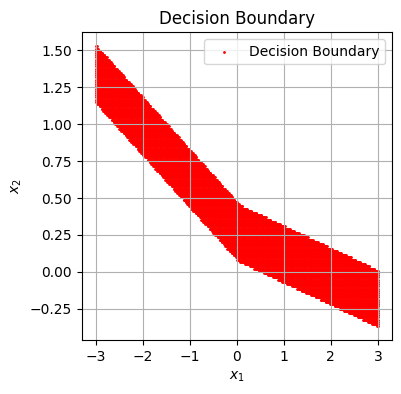

In [21]:
import matplotlib.pyplot as plt
import numpy as np


# # ReLU and neural network functions
# def relu(x):
#     return np.maximum(0, x)

# def neural_network(x, W1, b1, W2, b2):
#     z1 = relu(np.dot(W1, x) + b1)
#     scores = np.dot(W2, z1) + b2
#     return scores

# Generate a grid of points
x_range = np.linspace(-3, 3, 400)
y_range = np.linspace(-3, 3, 400)
xx, yy = np.meshgrid(x_range, y_range)
grid = np.c_[xx.ravel(), yy.ravel()]

# Evaluate the neural network on the grid
scores = np.array([neural_network(point, W1, b1, W2, b2) for point in grid])
# Compute the difference in scores
score_diff = scores[:, 0] - scores[:, 1]

# Identify points where s1 is approximately equal to s2
boundary_indices = np.where(np.abs(score_diff) < 0.1)[0]

# Plot
plt.figure(figsize=(4, 4))
plt.scatter(grid[boundary_indices, 0], grid[boundary_indices, 1], color='red', s=1, label='Decision Boundary')
plt.title('Decision Boundary')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.grid(True)
plt.show()


## 1.B Using Pytorch

Test Accuracy: 90.00 %


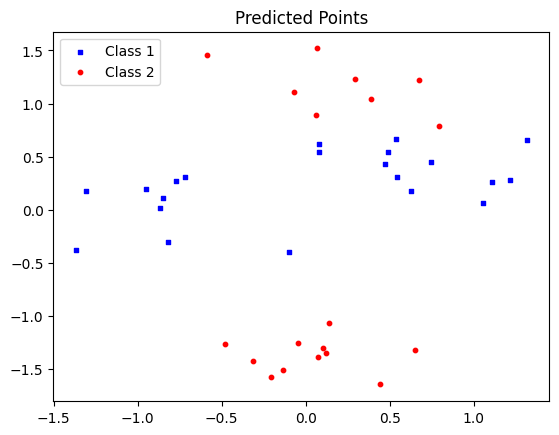

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read and shuffle the dataset
df = pd.read_csv('data_HW2_ex1.csv').sample(frac=1).reset_index(drop=True)

# Split into features and targets
x = np.column_stack((df['x1'].values, df['x2'].values))
y = df['class'].values

# One-hot encoding of the target variable
y = np.eye(y.max() + 1)[y]

# Convert arrays to PyTorch tensors
x_tensor = torch.tensor(x, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split into training and testing datasets
n_samples = x_tensor.shape[0]
n_train = int(0.8 * n_samples)

x_train, x_test = x_tensor[:n_train], x_tensor[n_train:]
y_train, y_test = y_tensor[:n_train], y_tensor[n_train:]

# Create DataLoader for training and testing
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 2)  # Input layer to hidden layer
        self.fc2 = nn.Linear(2, 3)  # Hidden layer to output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.softmax(self.fc2(x), dim=1)
        return x

model = Net()

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

# Training the model
for epoch in range(1000):  # Loop over the dataset multiple times
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize

# Evaluate the model
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        _, labels_max = torch.max(labels, 1)
        total += labels.size(0)
        correct += (predicted == labels_max).sum().item()

print('Test Accuracy: %.2f %%' % (100 * correct / total))

# Visualization of predicted points
predicted_op = []
x_test_np = x_test.numpy()
for inputs, _ in test_loader:
    outputs = model(inputs)
    predicted_op.extend(outputs.argmax(dim=1).numpy())

class_1x, class_1y, class_2x, class_2y = [], [], [], []
for i, pred in enumerate(predicted_op):
    if pred == 1:
        class_1x.append(x_test_np[i][0])
        class_1y.append(x_test_np[i][1])
    else:
        class_2x.append(x_test_np[i][0])
        class_2y.append(x_test_np[i][1])

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.scatter(class_1x, class_1y, s=10, c='b', marker="s", label='Class 1')
ax1.scatter(class_2x, class_2y, s=10, c='r', marker="o", label='Class 2')
plt.title("Predicted Points")
plt.legend(loc='upper left')
plt.show()


In [18]:

# Access weights and biases for the first layer (fc1)
fc1_weights = model.fc1.weight.data.numpy()
fc1_biases = model.fc1.bias.data.numpy()

# Access weights and biases for the second layer (fc2)
fc2_weights = model.fc2.weight.data.numpy()
fc2_biases = model.fc2.bias.data.numpy()

print("First Layer Weights:\n", fc1_weights)
print("First Layer Biases:\n", fc1_biases)
print("Second Layer Weights:\n", fc2_weights)
print("Second Layer Biases:\n", fc2_biases)


First Layer Weights:
 [[ 0.64495283 -3.5039728 ]
 [-0.38894176  3.629478  ]]
First Layer Biases:
 [-0.8495087 -0.2447468]
Second Layer Weights:
 [[-1.176986   -2.490183  ]
 [-1.3609371  -0.83728796]
 [ 1.8532492   1.5575299 ]]
Second Layer Biases:
 [-2.862711   3.2643847 -1.9675131]


## Lets compare accuracy with numerically estimated in 1.a

In [19]:
import pandas as pd
import numpy as np


# Neural network function using the optimized weights and biases
def neural_network(x, W1, b1, W2, b2):
    z1 = relu(np.dot(W1, x) + b1)
    scores = np.dot(W2, z1) + b2
    return scores

# Function to predict class based on neural network output
def predict_class(x, W1, b1, W2, b2):
    scores = neural_network(x, W1, b1, W2, b2)
    return np.argmax(scores)

# Load dataset
df = pd.read_csv('data_HW2_ex1.csv').sample(frac=1).reset_index(drop=True)
x = np.column_stack((df['x1'].values, df['x2'].values))
y = df['class'].values
y_one_hot = np.eye(y.max() + 1)[y]

# Predict classes for the dataset
y_pred = np.array([predict_class(xi, W1, b1, W2, b2) for xi in x])

# Calculate accuracy
accuracy = np.mean(y_pred == y)
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Test Accuracy: 25.00%


The model solved numerically was only able to get accuracy around 25% which is significantly lower than trained on PyTorch module.